#### 1/27/2018

# FB Amherst and Add Health \#23 analysis

## Summary

This notebook contains the Amherst-specific figures, the Add Health School figures for School \#23, and LINK figures for other schools. Code organization assumes working directory is notebook folder location.

## load libraries

In [1]:
## implemented LINK with solver='lbfgs'
from __future__ import division
from matplotlib.backends.backend_pdf import PdfPages
import os


## relevant libraries
execfile('../functions/python_libraries.py')

## file path
execfile('../functions/define_paths.py')


## processing datasets
execfile('../functions/create_adjacency_matrix.py') 
execfile('../functions/create_directed_adjacency_matrix.py')

execfile('../functions/SI_functions/LINK_finalized_coeff.py')


execfile('../functions/parsing.py')
execfile('../functions/mixing.py')

execfile('../functions/compute_homophily.py')
execfile('../functions/compute_monophily.py')
execfile('../functions/compute_homophily_p_value.py')
execfile('../functions/SI_functions/majority_vote_modified_SI.py')

## code for gender prediction 
execfile('../functions/LINK.py')
execfile('../functions/majority_vote.py')
execfile('../functions/ZGL.py')
execfile('../functions/benchmark_classifier.py')

## gender preference distribution
execfile('../functions/compute_null_distribution.py')

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/kristen/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/kristen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Amherst College Network from FB100

In [2]:
## load Amherst only

for f in listdir(fb100_file):
    if f.endswith('.mat'):
        tag = f.replace('.mat', '')
        if (tag == 'Amherst41'):
            print tag
            input_file = path_join(fb100_file, f)
            A, metadata = parse_fb100_mat_file(input_file)

            adj_matrix_tmp = A.todense()
            gender_y_tmp = metadata[:,1] #gender
                
            gender_dict = create_dict(range(len(gender_y_tmp)), gender_y_tmp)
                
            (gender_y, adj_matrix_gender) = create_adj_membership(
                                    nx.from_numpy_matrix(adj_matrix_tmp), # graph
                                                           gender_dict,   # dictionary
                                                           0,             # val_to_drop, gender = 0 is missing
                                                           'yes',         # delete_na_cols, ie completely remove NA nodes from graph
                                                           0,             # diagonal
                                                           None,          # directed_type
                                                           'gender')      # gender
            
            gender_y = np.array(map(np.int,gender_y)) ## need np.int for machine precisions reasons

Amherst41


In [3]:
F_fb_label = 1
M_fb_label = 2

# illustrate overdispersion in Amherst

In [4]:
#F
in_F_degree = adj_matrix_gender[gender_y==F_fb_label,] * np.matrix((gender_y==F_fb_label)+0).T
total_F_degree = np.sum(adj_matrix_gender[gender_y==F_fb_label,] ,1)
h_F = np.mean(in_F_degree)/np.mean(total_F_degree)

#M
in_M_degree = adj_matrix_gender[gender_y==M_fb_label,] * np.matrix((gender_y==M_fb_label)+0).T
total_M_degree = np.sum(adj_matrix_gender[gender_y==M_fb_label,] ,1)
h_M = np.mean(in_M_degree)/np.mean(total_M_degree)


# Evidence of overdispersion in gender preferences on the Amherst College network.

### [confirmed 100K is enough iterations]

In [5]:
n_iter = 100000
d_iF = map(np.int,np.array(total_F_degree.T)[0])

mc_F = []
for j in range(n_iter):
    mc_F.append( np.random.binomial(n=map(np.int,np.array(total_F_degree.T)[0]), p=h_F)/d_iF)
    
mc_F_final = np.array(mc_F).flatten()


d_iM = map(np.int,np.array(total_M_degree.T)[0])
mc_M = []
for j in range(n_iter):
    mc_M.append( np.random.binomial(n=map(np.int,np.array(total_M_degree.T)[0]), p=h_M)/d_iM)
    
mc_M_final = np.array(mc_M).flatten()

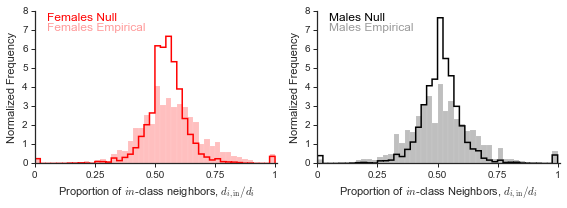

In [6]:
alpha_empirical = 0.4

%matplotlib inline
nbins = 45
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)


ax1.hist(in_F_degree/total_F_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.25)

ax1.hist(mc_F_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1.5)

ax1.set_ylabel('Normalized Frequency')
ax1.set_xlabel('Proportion of $in$-class neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,8)
ax1.set_xlim(0,1.01)

ax2.set_ylim(0,8)
ax2.set_xlim(0,1.01)
plt.setp(ax2, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)


ax2.hist(in_M_degree/total_M_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.25)
ax2.hist(mc_M_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax2.set_ylabel('Normalized Frequency')

ax1.annotate('Females Null', xy=(0.05,7.5), 
                 color='red', alpha=1, size=12)
ax1.annotate('Females Empirical', xy=(0.05,7), 
                 color='red', alpha=alpha_empirical, size=12)
ax2.annotate('Males Null', xy=(0.05,7.5), 
                 color='black', alpha=1, size=12)
ax2.annotate('Males Empirical', xy=(0.05,7), 
                 color='black', alpha=alpha_empirical, size=12)
plt.tight_layout()
#plt.title('test')
pp = PdfPages('../../figures/Facebook_Amherst_overdispersion_100k.pdf')
pp.savefig()
pp.close()

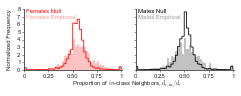

In [7]:
alpha_empirical = 0.4
%matplotlib inline
nbins = 45
text_size = 8
axis_text = 6

f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=True, sharex=False,
                            figsize=(3.46457,1.3),
                            squeeze = True)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])



ax1.minorticks_on()
ax1.tick_params('both', length=2, width=0.5, which='major', 
                left=1, bottom=1, top=0, right=0,  labelsize = axis_text,
               pad = 3.5)


ax1.hist(in_F_degree/total_F_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.25)

ax1.hist(mc_F_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=0.8)

ax1.set_ylabel('Normalized Frequency',
              size=axis_text)
#ax1.set_xlabel('Proportion of $in$-class neighbors, $d_{i,\\mathrm{in}}/d_i$',
#               size=text_size)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,8)
ax1.set_xlim(0,1.01)
ax1.spines["left"].set_linewidth(0.75)
ax1.spines["bottom"].set_linewidth(0.75)


ax2.set_ylim(0,8)
ax2.set_xlim(0,1.01)
plt.setp(ax2, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=2, width=0.5, which='major', left=1, bottom=1, top=0, right=0,
               labelsize = axis_text,
                pad = 3.5)


ax2.hist(in_M_degree/total_M_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.25)
ax2.hist(mc_M_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=0.8)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_linewidth(0.75)
ax2.spines["bottom"].set_linewidth(0.75)

ax1.annotate('Females Null', xy=(0.02,7.5), 
                 color='red', alpha=1, size=6)
ax1.annotate('Females Empirical', xy=(0.02,6.8), 
                 color='red', alpha=alpha_empirical, size=6)
ax2.annotate('Males Null', xy=(0.02,7.5), 
                 color='black', alpha=1, size=6)
ax2.annotate('Males Empirical', xy=(0.02,6.8), 
                 color='black', alpha=alpha_empirical, size=6)

plt.text(-0.65, -2.00, 'Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$', 
         fontsize=axis_text)

plt.tight_layout()
pp = PdfPages('../../figures/Facebook_Amherst_overdispersion_100k_SINGLE_COLUMN.pdf')
pp.savefig(dpi = 300)
pp.close()

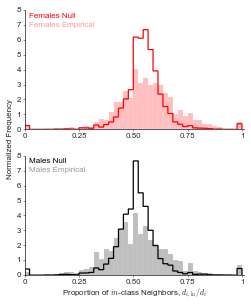

In [66]:
alpha_empirical = 0.4
%matplotlib inline
nbins = 45
text_size = 8
axis_text = 8

f, (ax1, ax2) = plt.subplots(2, 1, 
                             sharey=True, sharex=False,
                            figsize=(3.46457,4.2),
                            squeeze = True)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])



#ax1.minorticks_on()
ax1.tick_params('both', length=2, width=0.5, which='major', 
                left=1, bottom=1, top=0, right=0,  labelsize = axis_text,
               pad = 3.5)


ax1.hist(in_F_degree/total_F_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.25)

ax1.hist(mc_F_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1.25)

#ax1.set_ylabel('Normalized Frequency',
#              size=axis_text)
#ax1.set_xlabel('Proportion of $in$-class neighbors, $d_{i,\\mathrm{in}}/d_i$',
#               size=text_size)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,8)
ax1.set_xlim(0,1.01)
ax1.spines["left"].set_linewidth(0.75)
ax1.spines["bottom"].set_linewidth(0.75)


ax2.set_ylim(0,8)
ax2.set_xlim(0,1.01)
plt.setp(ax2, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
#ax2.minorticks_on()
ax2.tick_params('both', length=2, width=0.5, which='major', left=1, bottom=1, top=0, right=0,
               labelsize = axis_text,
                pad = 3.5)


ax2.hist(in_M_degree/total_M_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.25)
ax2.hist(mc_M_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.25)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_linewidth(0.75)
ax2.spines["bottom"].set_linewidth(0.75)
#ax2.get_lines()[1].set_visible(False)

ax1.annotate('Females Null', xy=(0.02,7.5), 
                 color='red', alpha=1, size=text_size)
ax1.annotate('Females Empirical', xy=(0.02,6.9), 
                 color='red', alpha=alpha_empirical, size=text_size)
ax2.annotate('Males Null', xy=(0.02,7.5), 
                 color='black', alpha=1, size=text_size)
ax2.annotate('Males Empirical', xy=(0.02,6.9), 
                 color='black', alpha=alpha_empirical, size=text_size)
plt.text(0.17, -1.34, 'Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$', 
         fontsize=axis_text)
plt.text(-0.08, 11.5, 'Normalized Frequency', 
         fontsize=axis_text,
        rotation = 'vertical')
plt.tight_layout()
pp = PdfPages('../../figures/Facebook_Amherst_overdispersion_100k_SINGLE_COLUMN_2x1.pdf')
pp.savefig(dpi = 300)
pp.close()

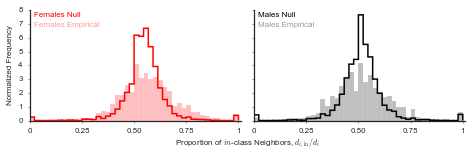

In [8]:
alpha_empirical = 0.4
%matplotlib inline
nbins = 45
text_size = 8
axis_text = 8
tick_label_size = 9.5

#fig = plt.figure(figsize=(3.46457,2.6), dpi = 300)

f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=True, sharex=False,
                            figsize=(6.69291,2.1),
                            squeeze = True)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])

ax1.minorticks_on()
ax1.tick_params('both', length=2, width=0.5, which='major', 
                left=1, bottom=1, top=0, right=0,  labelsize = axis_text)


ax1.hist(in_F_degree/total_F_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.25)

ax1.hist(mc_F_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1.5)

ax1.set_ylabel('Normalized Frequency',
              size=axis_text)
#ax1.set_xlabel('Proportion of $in$-class neighbors, $d_{i,\\mathrm{in}}/d_i$',
#               size=text_size)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,8)
ax1.set_xlim(0,1.01)

ax2.set_ylim(0,8)
ax2.set_xlim(0,1.01)
plt.setp(ax2, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=2, width=0.5, which='major', left=1, bottom=1, top=0, right=0,
               labelsize = axis_text)


ax2.hist(in_M_degree/total_M_degree,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.25)
ax2.hist(mc_M_final,
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax1.annotate('Females Null', xy=(0.02,7.5), 
                 color='red', alpha=1, size=text_size)
ax1.annotate('Females Empirical', xy=(0.02,6.8), 
                 color='red', alpha=alpha_empirical, size=text_size)
ax2.annotate('Males Null', xy=(0.02,7.5), 
                 color='black', alpha=1, size=text_size)
ax2.annotate('Males Empirical', xy=(0.02,6.8), 
                 color='black', alpha=alpha_empirical, size=text_size)

plt.text(-0.38, -1.78, 'Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$', 
         fontsize=axis_text)

plt.tight_layout()
pp = PdfPages('../../figures/Facebook_Amherst_overdispersion_100k_DOUBLE_COLUMN.pdf')
pp.savefig(dpi = 300)
pp.close()

In [9]:
## Amherst stats
print np.sum((gender_y==F_fb_label)+0)
print np.sum((gender_y==M_fb_label)+0)
print np.shape(adj_matrix_gender)

1015
1017
(2032, 2032)


In [10]:
print homophily_index_Jackson_alternative(adj_matrix_gender,
                                   gender_y)


[0.54765080958033996, 0.5121110920442995]


In [11]:
print homophily_intercept_p_value(adj_matrix_gender,
                         gender_y)

[[  6.43695879e-163]
 [  2.62405503e-011]]


In [12]:
print monophily_index_overdispersion_Williams(adj_matrix_gender,
                                   gender_y)


[0.03776731811765727, 0.040642558345226544]


# Comparison of 1-hop versus 2-hop classifiers on Amherst College.

In [13]:
n_iter = 100

### LINK Logistic Regression

In [14]:
percent_initially_unlabelled = [0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

In [15]:
(mean_accuracy_amherst, se_accuracy_amherst, 
 mean_micro_auc_amherst,se_micro_auc_amherst, mean_wt_auc_amherst_lbfgs,se_wt_auc_amherst)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(gender_y), ## gender labels 
                                                              np.matrix(adj_matrix_gender), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    solver='lbfgs',
                                                                                                    C=10e20),num_iter=n_iter) 

0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


## 1-hop MV

In [16]:
(mean_accuracy_mv_amherst, se_accuracy_mv_amherst, 
 mean_micro_auc_mv_amherst,se_micro_auc_mv_amherst, 
 mean_wt_auc_mv_amherst,se_wt_auc_mv_amherst) =majority_vote_modified(percent_initially_unlabelled,  
                                                                np.array(gender_y), 
                                                                np.array(adj_matrix_gender), 
                                                                       num_iter=n_iter)

0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide


### Note on warning message for 'true_divide': 
This warning message occurs in the sparsely labeled setting where a test node may have 0-labeled neighbors in which case there's a divide-by 0 issue with how the code is set-up in these cases. For these observations with 0-labeled neighbors, note that as explained in the SI, we assign a score based on the relative proportions in the training sample.
 

In [17]:
## SI figures
(mean_accuracy_mv_amherst_SI, se_accuracy_mv_amherst_SI, 
 mean_micro_auc_mv_amherst_SI, se_micro_auc_mv_amherst_SI, 
 mean_wt_auc_mv_amherst_SI, se_wt_auc_mv_amherst_SI,
 mean_accuracy_mv_amherstF_SI, se_accuracy_mv_amherstF_SI,
 mean_accuracy_mv_amherstM_SI, se_accuracy_mv_amherstM_SI) = majority_vote_modified_SI(percent_initially_unlabelled,  
                                                                np.array(gender_y), 
                                                                np.array(adj_matrix_gender), 
                                                                       num_iter=n_iter)




0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide


## 2-hop MV

In [18]:
adj_amherst2= np.matrix(adj_matrix_gender)**2
adj_amherst2[range(adj_amherst2.shape[0]),range(adj_amherst2.shape[0])]=0 ## remove self-loops

In [19]:
(mean_accuracy_mv2_amherst2, se_accuracy_mv2_amherst2, 
 mean_micro_auc_mv2_amherst2,se_micro_auc_mv2_amherst2, 
 mean_wt_auc_mv2_amherst2,se_wt_auc_mv2_amherst2) =majority_vote_modified(percent_initially_unlabelled,  
                                                                np.array(gender_y), 
                                                                np.array(adj_amherst2), 
                                                                num_iter=n_iter) 



0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide


In [20]:
## SI figures
(mean_accuracy_mv2_amherst_SI, se_accuracy_mv2_amherst_SI, 
 mean_micro_auc_mv2_amherst_SI,se_micro_auc_mv2_amherst_SI, 
 mean_wt_auc_mv2_amherst_SI,se_wt_auc_mv2_amherst_SI,
mean_accuracy_mv2_amherstF_SI, se_accuracy_mv2_amherstF_SI,
mean_accuracy_mv2_amherstM_SI, se_accuracy_mv2_amherstM_SI) =majority_vote_modified_SI(percent_initially_unlabelled,  
                                                                np.array(gender_y), 
                                                                np.array(adj_amherst2), 
                                                                       num_iter=n_iter)



0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide


## ZGL

In [21]:
(mean_accuracy_zgl_amherst, se_accuracy_zgl_amherst, 
mean_micro_auc_zgl_amherst,se_micro_auc_zgl_amherst, 
mean_wt_auc_zgl_amherst,se_wt_auc_zgl_amherst) =ZGL_finalized(np.array(adj_matrix_gender),
                                    np.array(gender_y),percent_initially_unlabelled, 
                                    num_iter=n_iter)

0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


/Users/kristen/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Baseline Classifier

In [22]:
(mean_wt_auc_baseline_amherst,se_wt_auc_baseline_amherst) = random_classifier(np.array(adj_matrix_gender),
                                                                             np.array(gender_y),
                                                                             percent_initially_unlabelled,
                                                                             num_iter=n_iter)

0.99
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05
0.01


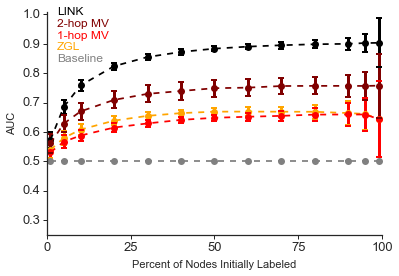

In [23]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter

fig = plt.figure()
seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')
for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.4, 0.5,0.6,0.7,0.8,0.9,1]))

        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_amherst_lbfgs, 
            yerr=se_wt_auc_amherst, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='black')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_zgl_amherst,
            yerr=se_wt_auc_zgl_amherst, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='orange')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_mv_amherst,
            yerr=se_wt_auc_mv_amherst, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='red')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_mv2_amherst2, 
            yerr=se_wt_auc_mv2_amherst2, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='maroon')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_baseline_amherst, 
            yerr=se_wt_auc_baseline_amherst, fmt='--o', capthick=2,
           alpha=1, elinewidth=3, color='gray')
        
        grid[i].set_ylim(0.3,1.1)
        grid[i].set_xlim(0,101)
        grid[i].annotate('LINK', xy=(3, 1.00), 
                 color='black', alpha=1, size=12)
        grid[i].annotate('2-hop MV', xy=(3, 0.96), 
                 color='maroon', alpha=1, size=12)
        grid[i].annotate('1-hop MV', xy=(3, 0.92), 
                 color='red', alpha=1, size=12)
        grid[i].annotate('ZGL', xy=(3, 0.88), 
                 color='orange', alpha=1, size=12)
        grid[i].annotate('Baseline', xy=(3, 0.84), 
                 color='gray', alpha=1, size=12)
        #grid[i].set_ylim(0.49,1.01)
        grid[i].set_ylim(0.25,1.01)
        grid[i].set_xlim(0,100)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=13)
        grid[i].tick_params(axis='both', which='minor', labelsize=13)
        grid[i].set_xlabel('Percent of Nodes Initially Labeled')
        grid[i].set_ylabel('AUC')

#plt.setp(ax1, xticks=[0,25, 50, 75, 100], xticklabels=['0', '25', '50', '75', '100'])
grid[0].set_xticks([0,25, 50, 75, 100])
grid[0].set_yticks([0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1])


grid[0].minorticks_on()
grid[0].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
#plt.show()
pp = PdfPages('../../figures/Amherst_College_Inference.pdf')
pp.savefig()
pp.close()

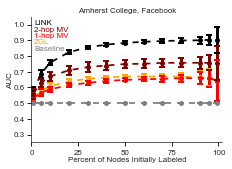

In [24]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter

fig = plt.figure(figsize=(6.69291/2,2.5), dpi = 300)
text_size = 8
axis_text = 8
tick_label_size = 7
msize = 5
seaborn.set_style(style='white')
pad = 0#.1
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=1, label_mode='L')
for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.4, 0.5,0.6,0.7,0.8,0.9,1]))
        
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_amherst_lbfgs, 
            yerr=se_wt_auc_amherst, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='black', markersize = msize)
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_zgl_amherst,
            yerr=se_wt_auc_zgl_amherst, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='orange', markersize = msize)
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_mv_amherst,
            yerr=se_wt_auc_mv_amherst, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='red', markersize = msize)
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_mv2_amherst2, 
            yerr=se_wt_auc_mv2_amherst2, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='maroon', markersize = msize)
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_baseline_amherst, 
            yerr=se_wt_auc_baseline_amherst, fmt='--o', capthick=2,
           alpha=1, elinewidth=3, color='gray', markersize = msize)
        
        grid[i].annotate('LINK', xy=(1.5, 1.00), 
                 color='black', alpha=1, size=text_size)
        grid[i].annotate('2-hop MV', xy=(1.5, 0.96), 
                 color='maroon', alpha=1, size=text_size)
        grid[i].annotate('1-hop MV', xy=(1.5, 0.92), 
                 color='red', alpha=1, size=text_size)
        grid[i].annotate('ZGL', xy=(1.5, 0.88), 
                 color='orange', alpha=1, size=text_size)
        grid[i].annotate('Baseline', xy=(1.5, 0.84), 
                 color='gray', alpha=1, size=text_size)
        
        
        grid[i].set_ylim(0.25,1.05)

        grid[i].set_xlim(0,102)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].spines["left"].set_linewidth(0.75)
        grid[i].spines["bottom"].set_linewidth(0.75)
        #grid[i].tick_params('both', length=2, width=0.5, which='major', 
        #        pad = 3.5,labelsize = axis_text)
        grid[i].tick_params(axis='both', which='major', labelsize=axis_text,
                           length = 0.1,
                           width = 0.5)
        grid[i].tick_params(axis='both', which='minor', labelsize=axis_text)
        grid[i].set_xlabel('Percent of Nodes Initially Labeled', size = axis_text,labelpad = pad)
        grid[i].set_ylabel('AUC', size = axis_text,labelpad = pad)

grid[0].set_xticks([0,25, 50, 75, 100])
grid[0].set_title('Amherst College, Facebook', size = text_size)


grid[0].set_yticks([0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1])
grid[0].minorticks_on()
grid[0].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
#plt.show()
plt.tight_layout()


pp = PdfPages('../../figures/Amherst_College_Inference_NHB_title.pdf')
pp.savefig(dpi = 300)
pp.close()

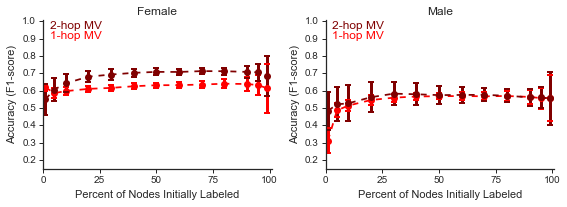

In [22]:
alpha_empirical = 0.4

%matplotlib inline
nbins = 25
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
plt.setp(ax1, xticks=[0,25, 50, 75, 100], xticklabels=['0', '25', '50', '75', '100'])
ax1.set_xticks([0,25, 50, 75, 100])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax1.errorbar(percent_initially_labelled*100, mean_accuracy_mv_amherstF_SI,
            yerr=se_accuracy_mv_amherstF_SI, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='red')
ax1.errorbar(percent_initially_labelled*100, mean_accuracy_mv2_amherstF_SI, 
            yerr=se_accuracy_mv2_amherstF_SI, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='maroon')
ax1.set_ylabel('Accuracy (F1-score)')
ax1.set_xlabel('Percent of Nodes Initially Labeled')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0.15,1.01)

ax1.set_xlim(0,101)
ax1.set_title('Female')


#ax2.set_ylim(0,16)
ax2.set_xlim(0,101)
plt.setp(ax2, xticks=[0,25, 50, 75, 100], xticklabels=['0', '25', '50', '75', '100'])
ax2.set_xticks([0,25, 50, 75, 100])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)

ax2.errorbar(percent_initially_labelled*100, mean_accuracy_mv_amherstM_SI,
            yerr=se_accuracy_mv_amherstM_SI, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='red')
ax2.errorbar(percent_initially_labelled*100, mean_accuracy_mv2_amherstM_SI, 
            yerr=se_accuracy_mv2_amherstM_SI, fmt='--o', capthick=2,
                alpha=1, elinewidth=3, color='maroon')
ax2.set_ylim(0.15,1.01)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_xlabel('Percent of Nodes Initially Labeled')
ax2.set_ylabel('Accuracy (F1-score)')
ax2.set_title('Male')
ax1.annotate('2-hop MV', xy=(3, 0.96), 
                 color='maroon', alpha=1, size=12)
ax1.annotate('1-hop MV', xy=(3, 0.90), 
                 color='red', alpha=1, size=12)
ax2.annotate('2-hop MV', xy=(3, 0.96), 
                 color='maroon', alpha=1, size=12)
ax2.annotate('1-hop MV', xy=(3, 0.90), 
                 color='red', alpha=1, size=12)

plt.tight_layout()
pp = PdfPages('../../figures/Amherst_College_SIFigure_Accuracy.pdf')
pp.savefig()
pp.close()

## SI Figures. Regularization for LINK Logistic Regression

### l2 regularization

0
1
2


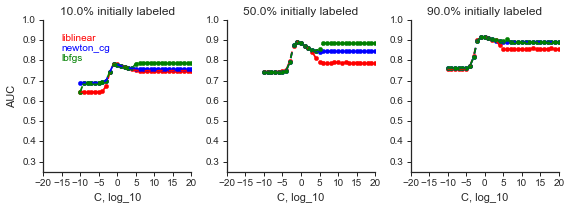

In [23]:
percent_initially_unlabelled = np.array([0.9,0.5,0.1])
percent_initially_labelled = 1-percent_initially_unlabelled
%matplotlib inline
f, (ax1, ax2,ax3) = plt.subplots(1, 3, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
C_min = -10
for i in range(len(percent_initially_unlabelled)):
    print i
    k_fold = cross_validation.ShuffleSplit(len(gender_y), n_iter=1,
                                                test_size=percent_initially_unlabelled[i],
                                                random_state=0)

    for k, (train, test) in enumerate(k_fold):
        ## vary C values
        C_vals = [10**x for x in range(C_min,100)]#range(-20,100)]

        ## vary solver types
        solver_type = np.array(['liblinear',
                                   'newton-cg',
                                   'lbfgs'])

        liblinear_AUC = []
        newton_cg_AUC = []
        lbfgs_AUC = []
        for j in range(len(C_vals)):
            for m in range(len(solver_type)):
                clf = linear_model.LogisticRegression(penalty='l2',
                                                    C=C_vals[j],
                                                    solver =solver_type[m])
                clf.fit(adj_matrix_gender[train], np.ravel(gender_y[train])) # spot-check fitted on training data


                pred = clf.predict(adj_matrix_gender[train]) # spot-check fitted on testing data
                prob = clf.predict_proba(adj_matrix_gender[test])

                if solver_type[m]=='liblinear':
                    liblinear_AUC.append(metrics.roc_auc_score(label_binarize(gender_y[test],np.unique(gender_y)),
                                                                    prob[:,1],average='weighted'))
                if solver_type[m]=='newton-cg':
                    newton_cg_AUC.append(metrics.roc_auc_score(label_binarize(gender_y[test],np.unique(gender_y)),
                                                                    prob[:,1],average='weighted'))
                if solver_type[m]=='lbfgs':
                    lbfgs_AUC.append(metrics.roc_auc_score(label_binarize(gender_y[test],np.unique(gender_y)),
                                                                    prob[:,1],average='weighted'))
    if i==0:
        ax1.minorticks_on()
        ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
        ax1.set_xlabel('C, log_10')
        ax1.scatter(range(C_min,100), liblinear_AUC, color='red')#,'.r-')
        ax1.plot(range(C_min,100), liblinear_AUC, 'r--')
        ax1.scatter(range(C_min,100), newton_cg_AUC, color='blue')#,'.b-')
        ax1.plot(range(C_min,100), newton_cg_AUC, 'b--')
        ax1.scatter(range(C_min,100), lbfgs_AUC, color='green')#,'.g-')
        ax1.plot(range(C_min,100), lbfgs_AUC, 'g--')
        ax1.annotate('liblinear', xy=(-15,0.90), color = 'red')
        ax1.annotate('newton_cg', xy=(-15,0.85), color = 'blue')
        ax1.annotate('lbfgs', xy=(-15,0.8), color = 'green')
        ax1.spines["right"].set_visible(False)
        ax1.spines["top"].set_visible(False)
        ax1.set_title(str(percent_initially_labelled[i]*100) +'% initially labeled')
        ax1.set_ylabel('AUC')
        ax1.set_ylim(0.25,1)
        ax1.set_xlim(-20,20)


    if i==1:
        ax2.scatter(range(C_min,100), liblinear_AUC, color='red')#,'.r-')
        ax2.plot(range(C_min,100), liblinear_AUC, 'r--')
        ax2.minorticks_on()
        ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
        ax2.set_xlabel('C, log_10')
        ax2.scatter(range(C_min,100), newton_cg_AUC, color='blue')#,'.b-')
        ax2.plot(range(C_min,100), newton_cg_AUC, 'b--')
        ax2.scatter(range(C_min,100), lbfgs_AUC, color='green')#,'.g-')
        ax2.plot(range(C_min,100), lbfgs_AUC, 'g--')
        ax2.spines["right"].set_visible(False)
        ax2.spines["top"].set_visible(False)
        ax2.set_title(str(percent_initially_labelled[i]*100) +'% initially labeled')
        ax2.set_ylim(0.25,1)
        ax2.set_xlim(-20,20)



    if i==2:
        ax3.scatter(range(C_min,100), liblinear_AUC, color='red')#,'.r-')
        ax3.plot(range(C_min,100), liblinear_AUC, 'r--')
        ax3.scatter(range(C_min,100), newton_cg_AUC, color='blue')#,'.b-')
        ax3.plot(range(C_min,100), newton_cg_AUC, 'b--')
        ax3.minorticks_on()
        ax3.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
        ax3.set_xlabel('C, log_10')
        ax3.scatter(range(C_min,100), lbfgs_AUC, color='green')#,'.g-')
        ax3.plot(range(C_min,100), lbfgs_AUC, 'g--')
        ax3.spines["right"].set_visible(False)
        ax3.spines["top"].set_visible(False)
        ax3.set_title(str(percent_initially_labelled[i]*100) +'% initially labeled')
        ax3.set_ylim(0.25,1)
        ax3.set_xlim(-20,20)
    plt.tight_layout()
    pp = PdfPages('../../figures/FB_Amherst_sensitivity_to_C.pdf')
    pp.savefig()
    pp.close()    

### l1 regularization

0
1
2


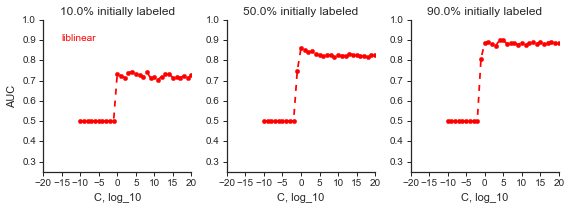

In [24]:
## spotcheck_only
%matplotlib inline
f, (ax1, ax2,ax3) = plt.subplots(1, 3, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
for i in range(len(percent_initially_unlabelled)):
    print i
    k_fold = cross_validation.ShuffleSplit(len(gender_y), n_iter=1,
                                                test_size=percent_initially_unlabelled[i],
                                                random_state=0)


    for k, (train, test) in enumerate(k_fold):
        ## vary C values
        C_vals = [10**x for x in range(C_min,100)]

        ## vary solver types
        solver_type = np.array(['liblinear'])
        liblinear_AUCl1 = []
        for j in range(len(C_vals)):
            for m in range(len(solver_type)):
                clf = linear_model.LogisticRegression(penalty='l1',
                                                    C=C_vals[j],
                                                    solver =solver_type[m])
                clf.fit(adj_matrix_gender[train], np.ravel(gender_y[train])) # spot-check fitted on training data


                pred = clf.predict(adj_matrix_gender[train]) # spot-check fitted on testing data
                prob = clf.predict_proba(adj_matrix_gender[test])

                if solver_type[m]=='liblinear':
                    liblinear_AUCl1.append(metrics.roc_auc_score(label_binarize(gender_y[test],np.unique(gender_y)),
                                                                    prob[:,1],average='weighted'))
               
           
    if i==0:
        ax1.scatter(range(C_min,100), liblinear_AUCl1, color='red')#,'.r-')
        ax1.plot(range(C_min,100), liblinear_AUCl1, 'r--')

        ax1.minorticks_on()
        ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
        ax1.set_xlabel('C, log_10')
        ax1.annotate('liblinear', xy=(-15,0.90), color = 'red')
        ax1.spines["right"].set_visible(False)
        ax1.spines["top"].set_visible(False)
        ax1.set_title(str(percent_initially_labelled[i]*100) +'% initially labeled')
        ax1.set_ylabel('AUC')
        ax1.set_ylim(0.25,1)
        ax1.set_xlim(-20,20)
        
    if i==1:
        ax2.scatter(range(C_min,100), liblinear_AUCl1, color='red')#,'.r-')
        ax2.plot(range(C_min,100), liblinear_AUCl1, 'r--')
        ax2.spines["right"].set_visible(False)
        ax2.spines["top"].set_visible(False)
        ax2.set_title(str(percent_initially_labelled[i]*100) +'% initially labeled')
        ax2.set_ylim(0.25,1)
        ax2.set_xlim(-20,20)
        ax2.minorticks_on()
        ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
        ax2.set_xlabel('C, log_10')

    if i==2:
        ax3.scatter(range(C_min,100), liblinear_AUCl1, color='red')#,'.r-')
        ax3.plot(range(C_min,100), liblinear_AUCl1, 'r--')
        ax3.spines["right"].set_visible(False)
        ax3.spines["top"].set_visible(False)
        ax3.set_title(str(percent_initially_labelled[i]*100) +'% initially labeled')
        ax3.set_ylim(0.25,1)
        ax3.set_xlim(-20,20)
        ax3.minorticks_on()
        ax3.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
        ax3.set_xlabel('C, log_10')
    plt.tight_layout()
    pp = PdfPages('../../figures/FB_Amherst_sensitivity_to_C_l1.pdf')
    pp.savefig()
    pp.close()

## SI Figure. Separability on Amherst College

In [25]:
def LINK_training(num_unlabeled, membership_y, feature_x, clf, num_iter, cv_setup=None):
    mean_accuracy = []
    se_accuracy = []
    mean_micro_auc = []
    se_micro_auc = []
    mean_wt_auc = []
    se_wt_auc = []
    
        
    for i in range(len(num_unlabeled)):
        print num_unlabeled[i]
        if cv_setup=='stratified':
            k_fold = cross_validation.StratifiedShuffleSplit((membership_y), n_iter=num_iter,
                                               test_size=num_unlabeled[i],
                                               random_state=0)
        else:
            k_fold = cross_validation.ShuffleSplit(len(membership_y), n_iter=num_iter,
                                                         test_size=num_unlabeled[i],
                                                         random_state=0)
        accuracy = []
        micro_auc = []
        wt_auc = []
        for k, (train, test) in enumerate(k_fold):
            clf.fit(feature_x[train], np.ravel(membership_y[train]))
            
            # predicted labels
            pred = clf.predict(feature_x[train])
            prob = clf.predict_proba(feature_x[train])

            accuracy.append(metrics.accuracy_score(membership_y[train], pred,  normalize = True))
                                                                                 
            # auc scores
            if len(np.unique(membership_y))>2:
                micro_auc.append(metrics.roc_auc_score(label_binarize(membership_y[train],
                                                                      np.unique(membership_y)), prob,  average = 'micro'))
                wt_auc.append(metrics.roc_auc_score(label_binarize(membership_y[train],
                                                                   np.unique(membership_y)), prob,
                                                                                                                             average = 'weighted'))
            else:
                micro_auc.append(metrics.roc_auc_score(label_binarize(membership_y[train],
                                                                      np.unique(membership_y)),
                                                                        prob[:,1],average='micro'))
                wt_auc.append(metrics.roc_auc_score(label_binarize(membership_y[train],
                                                                   np.unique(membership_y)),
                                                                            prob[:,1],average='weighted'))
    
        mean_accuracy.append(np.mean(accuracy))
        se_accuracy.append(np.std(accuracy))

        mean_micro_auc.append(np.mean(micro_auc))
        se_micro_auc.append(np.std(micro_auc))
        mean_wt_auc.append(np.mean(wt_auc))
        se_wt_auc.append(np.std(wt_auc))

    return(mean_accuracy, se_accuracy, mean_micro_auc,se_micro_auc, mean_wt_auc,se_wt_auc)

In [26]:
percent_initially_unlabelled = [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

In [27]:
(t1, t1,
 t1, t2, 
 mean_auc_l2_unregularized_training_C100, 
 se_auc_l2_unregularized_training_C100) = LINK_training(percent_initially_unlabelled,
                                                        gender_y,
                                                        adj_matrix_gender,
                                                        clf = linear_model.LogisticRegression(
                                                            penalty='l2',C=10e20, solver='lbfgs'), 
                                                        num_iter=n_iter, cv_setup=None)

0.99
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [28]:
C_array = np.logspace(-5, 5, num=50, endpoint=True)

In [32]:
(t1, t1, t1, t2,  mean_auc_l2_regularized_training, se_auc_l2_regularized_training) = LINK_training(percent_initially_unlabelled,  
                                                gender_y,
                                                adj_matrix_gender,
                                                clf = linear_model.LogisticRegressionCV(
                                                    C_array,penalty='l2',solver='lbfgs'), 
                                                num_iter=n_iter, cv_setup=None)

0.99
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [33]:
(t1, t1,
 t1, t2, 
 mean_auc_l2_unregularized, 
 se_auc_l2_unregularized) = LINK(percent_initially_unlabelled,  
                                 gender_y,
                                 adj_matrix_gender,
                                 clf = linear_model.LogisticRegression(
                                     penalty='l2',C=10e20, solver='lbfgs'), 
                                 num_iter=n_iter, cv_setup=None)

0.99
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [34]:
(t1, t1,
 t1, t2, 
 mean_auc_l2_regularized, 
 se_auc_l2_regularized) = LINK(percent_initially_unlabelled,
                               gender_y,
                               adj_matrix_gender,
                               clf = linear_model.LogisticRegressionCV(C_array,penalty='l2',
                                  solver='lbfgs',cv=5), 
                               num_iter=n_iter, cv_setup=None)

0.99
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


/Users/kristen/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


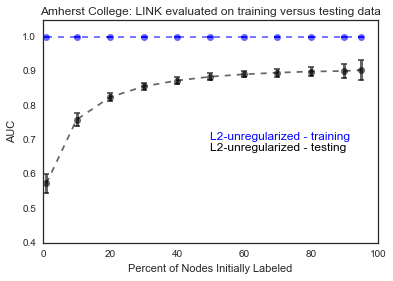

In [35]:
%matplotlib inline

plt.errorbar(percent_initially_labelled*100, mean_auc_l2_unregularized, 
                     yerr=se_auc_l2_unregularized, fmt='--o', capthick=2,
                     alpha=0.6, elinewidth=3, color='black')

plt.errorbar(percent_initially_labelled*100, mean_auc_l2_unregularized_training_C100, 
                     yerr=se_auc_l2_unregularized_training_C100, fmt='--o', capthick=2,
                     alpha=0.6, elinewidth=3, color='blue')

plt.title('Amherst College: LINK evaluated on training versus testing data')

plt.annotate('L2-unregularized - testing', xy=(50, 0.67), 
             color='black', alpha=1, size=12)

plt.annotate('L2-unregularized - training', xy=(50, 0.7), 
             color='blue', alpha=1, size=12)

plt.ylim(*(0.4,1.05))
plt.xlabel('Percent of Nodes Initially Labeled')
plt.ylabel('AUC')
pp = PdfPages('../../figures/Amherst_LINK_training_testing_separability.pdf')
pp.savefig()
pp.close()

# illustrate overdispersion in Add Health School #23

In [36]:
for f in listdir(add_health_file):
    if f.endswith('.gml') and f=='comm23.gml': 
        tag = f.replace('.gml', '')
        print tag

        id = re.findall(r'\d+', f)
        print "Processing %s..." % f

        # directed graph
        ah_graph_directed = nx.read_gml(add_health_file+f)

        # for mutual links
        t1 = nx.adj_matrix(ah_graph_directed).todense()
        t2 = np.copy(t1.T)
        final = ((t1+t2) > 0)+0
        
        # undirected graph
        ah_graph_tmp = nx.read_gml(add_health_file+f)
        ah_graph_undirected = ah_graph_tmp.to_undirected()
        
        ## Add Health -- Undirected: Either In- or Out- Link
        (ah_gender_both, adj_gender_both) = create_adj_membership(nx.from_numpy_matrix(final),
                                                                   nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'),
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   None, # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')
  
             

        (ah_gender_undirected, adj_directed_gender_undirected) = create_adj_membership(nx.from_numpy_matrix(final),
                                                                   nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'),
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   None, # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')
        ah_gender_undirected = np.array(map(np.int,ah_gender_undirected))


        #in
        (ah_gender_in, adj_gender_in) = create_directed_adj_membership(ah_graph_directed,
                                                                nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'), ## fix for non-mutual links here
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   'in', # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')
        ah_gender_in = np.array(map(np.int,ah_gender_in))


        #out-link
        (ah_gender_out, adj_gender_out) = create_directed_adj_membership(ah_graph_directed,
                                                                nx.get_node_attributes(ah_graph_directed, 
                                                                                       'comm' + str(id[0]) +'sex'), ## fix for non-mutual links here
                                                                   0,
                                                                   'yes',
                                                                   0,
                                                                   'out', # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                   'gender')
        ah_gender_out = np.array(map(np.int,ah_gender_out))


comm23
Processing comm23.gml...


In [37]:
percent_initially_unlabelled = [0.1]#[0.99,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

In [38]:
n_iter = 1

In [39]:
coef= LINK_coeff(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_undirected), ## gender labels 
                                                              np.matrix(adj_directed_gender_undirected), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',C=10e20,
                                                                                                   solver='lbfgs'),num_iter=n_iter) 





0.1


In [40]:
np.unique(ah_gender_undirected)

array([1, 2])

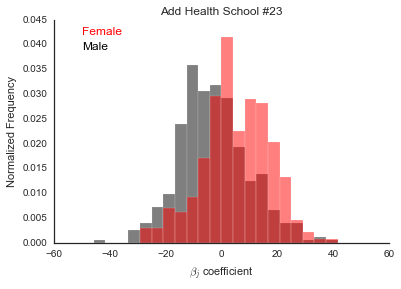

In [41]:
%matplotlib inline
ax = plt.subplot(111)
alpha_parameter = 0.5
binBoundaries=np.linspace(-50,50,num=25)

ax.hist(coef[np.array(ah_gender_undirected)==1], color='black', #alpha=0.1,
        bins=binBoundaries, 
                     normed = True,
                     alpha = alpha_parameter, label='empirical',
                    edgecolor = 'white')

ax.hist(coef[np.array(ah_gender_undirected)==2], color='red', #alpha=0.1,
        bins=binBoundaries, 
                     normed = True,
                     alpha = alpha_parameter, label='empirical',
                    edgecolor = 'white')
plt.xlabel(r'$\beta_j$ coefficient')
plt.ylabel('Normalized Frequency')
plt.title('Add Health School #23')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('Female', xy=(-50, 0.042), 
                 color='red', alpha=1, size=12)

ax.annotate('Male', xy=(-50, 0.039), 
                 color='black', alpha=1, size=12)

pp = PdfPages('../../figures/Add_Health_23_undirected_Butterfly_actual_class_histogram.pdf')
pp.savefig()
pp.close()

# Null Distribution for Add Health

In [42]:
add_health_null =  compute_null_distribution(adj_directed_gender_undirected, 
                                ah_gender_undirected, 
                                100000)

In [43]:
add_health_obs = compute_observed_same_total_degree(adj_directed_gender_undirected, 
                                ah_gender_undirected)

In [44]:
print np.unique(ah_gender_undirected)
print np.mean(ah_gender_undirected==1)
print np.mean(ah_gender_undirected==2)

[1 2]
0.540540540541
0.459459459459


# SI Figures. 

### undirected graph

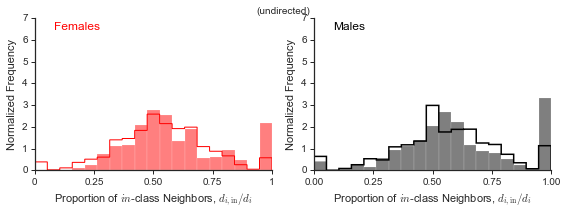

In [45]:
%matplotlib inline
nbins = 20
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
ax1.hist(add_health_obs[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.5)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_ylabel('Normalized Frequency')
ax1.set_ylabel('Normalized Frequency')
ax2.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax1.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')


ax1.hist(add_health_null[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1)

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,7)
ax2.set_ylim(0,7)



ax2.hist(add_health_obs[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.5)

ax2.hist(add_health_null[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)



#f.text(0.5, 0.01, 'Proportion of $in$-class degrees, $d_{i,in}/d_i$', ha='center',size=10)
f.text(0.5, 0.95, '(undirected)', ha='center',size=10)
ax1.annotate('Females', xy=(0.08,6.5), 
                 color='red', alpha=1, size=12)

ax2.annotate('Males', xy=(0.08,6.5), 
                 color='black', alpha=1, size=12)


plt.tight_layout()

#plt.show()
pp = PdfPages('../../figures/Add_Health_23_undirected_overdispersion_100k.pdf')
pp.savefig()
pp.close()

## in-directed

In [46]:
add_health_null =  compute_null_distribution(adj_gender_in, 
                                ah_gender_in, 
                                100000)
add_health_obs = compute_observed_same_total_degree(adj_gender_in, 
                                ah_gender_in)

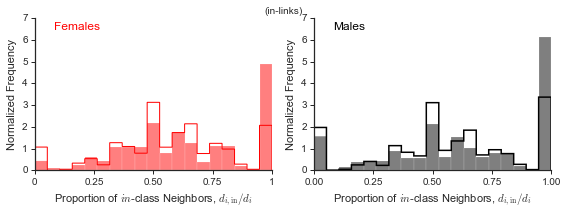

In [47]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
ax1.hist(add_health_obs[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.5)

ax1.hist(add_health_null[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_ylabel('Normalized Frequency')
ax1.set_ylabel('Normalized Frequency')
ax2.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax1.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,7)
ax2.set_ylim(0,7)



ax2.hist(add_health_obs[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.5)

ax2.hist(add_health_null[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

f.text(0.5, 0.95, '(in-links)', ha='center',size=10)
ax1.annotate('Females', xy=(0.08,6.5), 
                 color='red', alpha=1, size=12)

ax2.annotate('Males', xy=(0.08,6.5), 
                 color='black', alpha=1, size=12)


plt.tight_layout()


pp = PdfPages('../../figures/Add_Health_23_indirected_overdispersion_100k.pdf')
pp.savefig()
pp.close()

## out-directed

In [48]:
add_health_null =  compute_null_distribution(adj_gender_out, 
                                ah_gender_out, 
                                100000)
add_health_obs = compute_observed_same_total_degree(adj_gender_out, 
                                ah_gender_out)




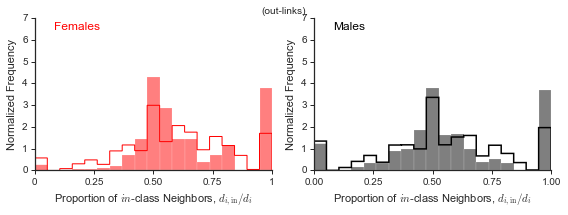

In [49]:
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, 
                             sharey=False, sharex=False,
                            figsize=(8, 3))
ax1.hist(add_health_obs[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='red',alpha=0.5)

ax1.hist(add_health_null[1],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'red',histtype='step',
        color='white',alpha=1,lw=1)
plt.setp(ax1, xticks=[0,0.25, 0.5, 0.75, 1], xticklabels=['0', '0.25', '0.50', '0.75', '1'])
ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_xticks([0,0.25, 0.5, 0.75, 1])
ax2.minorticks_on()
ax2.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
ax2.set_ylabel('Normalized Frequency')
ax1.set_ylabel('Normalized Frequency')
ax2.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')
ax1.set_xlabel('Proportion of $in$-class Neighbors, $d_{i,\\mathrm{in}}/d_i$')


#ax1.set_ylabel('Frequency')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim(0,7)
ax2.set_ylim(0,7)


ax2.hist(add_health_obs[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'white',
        color='black',alpha=0.5)

ax2.hist(add_health_null[0],
         bins = np.linspace(0,1,nbins),
         normed = True,
         edgecolor = 'black',histtype='step',
        color='white',alpha=1,lw=1.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

f.text(0.5, 0.95, '(out-links)', ha='center',size=10)
ax1.annotate('Females', xy=(0.08,6.5), 
                 color='red', alpha=1, size=12)

ax2.annotate('Males', xy=(0.08,6.5), 
                 color='black', alpha=1, size=12)


plt.tight_layout()


pp = PdfPages('../../figures/Add_Health_23_outdirected_overdispersion_100k.pdf')
pp.savefig()
pp.close()

## LINK Logistic Regression

In [50]:
percent_initially_unlabelled = [0.98,0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

In [51]:
n_iter = 100

In [52]:
#undirected
(mean_accuracy_ah_both, se_accuracy_ah_both, 
 mean_micro_auc_ah_both,se_micro_auc_ah_both, mean_wt_auc_ah_both,se_wt_auc_ah_both)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_both), ## gender labels 
                                                              np.array(adj_gender_both), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    C=10e20,
                                                                                                   solver='lbfgs'),
                                                                        num_iter=n_iter,
                                                            cv_setup='None') 





0.98
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [53]:
#undirected
(mean_accuracy_ah_undirect, se_accuracy_ah_undirect, 
 mean_micro_auc_ah_undirect,se_micro_auc_ah_undirect, mean_wt_auc_ah_undirect,se_wt_auc_ah_undirect)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_undirected), ## gender labels 
                                                              np.matrix(adj_directed_gender_undirected), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    C=10e20,
                                                                                                   solver='lbfgs'),
                                                                        num_iter=n_iter,
                                                            cv_setup='None') 




0.98
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [54]:
#in
(mean_accuracy_ah_in, se_accuracy_ah_in, 
 mean_micro_auc_ah_in,se_micro_auc_ah_in, mean_wt_auc_ah_in,se_wt_auc_ah_in)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_in), ## gender labels 
                                                              np.matrix(adj_gender_in), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    C=10e20,
                                                                                                   solver='lbfgs'),
                                                                        num_iter=n_iter,
                                                            cv_setup=None) 





0.98
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


In [55]:
#out
(mean_accuracy_ah_out, se_accuracy_ah_out, 
 mean_micro_auc_ah_out,se_micro_auc_ah_out, mean_wt_auc_ah_out,se_wt_auc_ah_out)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(ah_gender_out), ## gender labels 
                                                              np.matrix(adj_gender_out), ## adjacency matrix
                                                              clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                    C=10e20,
                                                                                                   solver='lbfgs'),
                                                                        num_iter=n_iter,
                                                            cv_setup=None) 






0.98
0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


## SI Figure . gender classification on school #23 in Add Health for in-, out-, and undirected versions of LINK

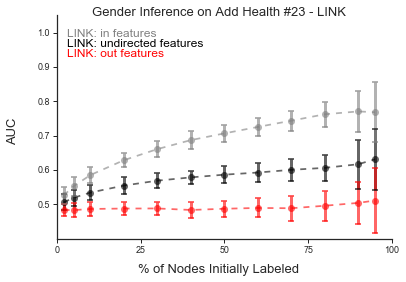

In [56]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter
fig = plt.figure()
seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')


for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.5,0.6,0.7,0.8,0.9,1]))

        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_undirect, 
            yerr=se_wt_auc_ah_undirect, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='black')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_in, 
            yerr=se_wt_auc_ah_in, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='red')
        
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_out,
            yerr=se_wt_auc_ah_out, fmt='--o', capthick=2,
            alpha=0.6, elinewidth=3, color='gray')
        
        
        grid[i].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)


        grid[i].set_ylim(0.4,1.1)
        grid[i].set_xlim(0,100)
        grid[i].annotate('LINK: in features', xy=(3, 0.99), 
                 color='gray', alpha=1, size=12)

        grid[i].annotate('LINK: undirected features', xy=(3, 0.96), 
                 color='black', alpha=1, size=12)
        grid[i].annotate('LINK: out features', xy=(3, 0.93), 
                 color='red', alpha=1, size=12)

        grid[i].set_ylim(0.4,1.05)
        grid[i].set_xlim(0,100)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=9)
        grid[i].tick_params(axis='both', which='minor', labelsize=9)


fig.text(0.5, 0.9, 'Gender Inference on Add Health #' +str(id[0]) + ' - LINK', ha='center', fontsize=13)        
fig.text(0.5, 0.01, '% of Nodes Initially Labeled', ha='center', fontsize=13)
fig.text(0.01, 0.5, 'AUC', va='center', rotation='vertical', fontsize=13)

pp = PdfPages('../../figures/AddHealth_School_23_LINK_Inference.pdf')
pp.savefig()
pp.close()

## LINK results for other AH schools

In [57]:
percent_initially_unlabelled = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

comm15
Processing comm15.gml...
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
comm16
Processing comm16.gml...
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
comm17
Processing comm17.gml...
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
comm18
Processing comm18.gml...
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
comm19
Processing comm19.gml...
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
comm20
Processing comm20.gml...
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
comm21
Processing comm21.gml...
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
comm22
Processing co

/Users/kristen/anaconda/lib/python2.7/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


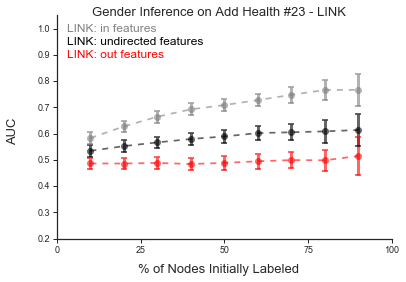

In [58]:
school_num_array = np.array(range(84))+1

for school_num in school_num_array:
    for f in listdir(add_health_file):
        if f.endswith('.gml') and f=='comm' + str(school_num) +'.gml' and school_num !=3 and school_num !=27 and school_num >=15 and school_num <=23:# and school_num <27: 
            tag = f.replace('.gml', '')
            print tag

            id = re.findall(r'\d+', f)
            print "Processing %s..." % f

            # directed graph
            ah_graph_directed = nx.read_gml(add_health_file+f)

            # for mutual links
            t1 = nx.adj_matrix(ah_graph_directed).todense()
            t2 = np.copy(t1.T)
            final = ((t1+t2) > 0)+0

            # undirected graph
            ah_graph_tmp = nx.read_gml(add_health_file+f)
            ah_graph_undirected = ah_graph_tmp.to_undirected()



            (ah_gender_undirected, adj_directed_gender_undirected) = create_adj_membership(nx.from_numpy_matrix(final),
                                                                       nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'),
                                                                       0,
                                                                       'yes',
                                                                       0,
                                                                       None, # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                       'gender')
            ah_gender_undirected = np.array(map(np.int,ah_gender_undirected))


            #in
            (ah_gender_in, adj_gender_in) = create_directed_adj_membership(ah_graph_directed,
                                                                    nx.get_node_attributes(ah_graph_directed, 'comm' + str(id[0]) +'sex'), ## fix for non-mutual links here
                                                                       0,
                                                                       'yes',
                                                                       0,
                                                                       'in', # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                       'gender')
            ah_gender_in = np.array(map(np.int,ah_gender_in))


            #out-link
            (ah_gender_out, adj_gender_out) = create_directed_adj_membership(ah_graph_directed,
                                                                    nx.get_node_attributes(ah_graph_directed, 
                                                                                           'comm' + str(id[0]) +'sex'), ## fix for non-mutual links here
                                                                       0,
                                                                       'yes',
                                                                       0,
                                                                       'out', # change adjacency matrix type: out == out-link, in == in-link, any1 == undirected
                                                                       'gender')
            ah_gender_out = np.array(map(np.int,ah_gender_out))






            n_iter = 100


            #undirected
            (mean_accuracy_ah_undirect, se_accuracy_ah_undirect, 
             mean_micro_auc_ah_undirect,se_micro_auc_ah_undirect, mean_wt_auc_ah_undirect,se_wt_auc_ah_undirect)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                                          np.array(ah_gender_undirected), ## gender labels 
                                                                          np.matrix(adj_directed_gender_undirected), ## adjacency matrix
                                                                          clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                                C=10e20,
                                                                                                               solver='lbfgs'),
                                                                                    num_iter=n_iter,
                                                                        cv_setup='stratified') 



            #in
            (mean_accuracy_ah_in, se_accuracy_ah_in, 
             mean_micro_auc_ah_in,se_micro_auc_ah_in, mean_wt_auc_ah_in,se_wt_auc_ah_in)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                                          np.array(ah_gender_in), ## gender labels 
                                                                          np.matrix(adj_gender_in), ## adjacency matrix
                                                                          clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                                C=10e20,
                                                                                                               solver='lbfgs'),
                                                                                    num_iter=n_iter,
                                                                        cv_setup='stratified') 



            #out
            (mean_accuracy_ah_out, se_accuracy_ah_out, 
             mean_micro_auc_ah_out,se_micro_auc_ah_out, mean_wt_auc_ah_out,se_wt_auc_ah_out)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                                          np.array(ah_gender_out), ## gender labels 
                                                                          np.matrix(adj_gender_out), ## adjacency matrix
                                                                          clf = linear_model.LogisticRegression(penalty='l2',
                                                                                                                C=10e20,
                                                                                                               solver='lbfgs'),
                                                                                    num_iter=n_iter,
                                                                        cv_setup='stratified') 







            %matplotlib inline
            from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter
            fig = plt.figure()
            seaborn.set_style(style='white')
            from mpl_toolkits.axes_grid1 import Grid
            grid = Grid(fig, rect=111, nrows_ncols=(1,1),
                        axes_pad=0.1, label_mode='L')


            for i in range(4):
                if i == 0:
                    grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
                    grid[i].yaxis.set_major_locator(FixedLocator([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))

                    grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_undirect, 
                        yerr=se_wt_auc_ah_undirect, fmt='--o', capthick=2,
                        alpha=0.6, elinewidth=3, color='black')

                    grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_in, 
                        yerr=se_wt_auc_ah_in, fmt='--o', capthick=2,
                        alpha=0.6, elinewidth=3, color='red')

                    grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_ah_out,
                        yerr=se_wt_auc_ah_out, fmt='--o', capthick=2,
                        alpha=0.6, elinewidth=3, color='gray')


                    grid[i].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)


                    grid[i].set_ylim(0.2,1.05)

                    grid[i].set_xlim(0,100)
                    grid[i].annotate('LINK: in features', xy=(3, 0.99), 
                             color='gray', alpha=1, size=12)

                    grid[i].annotate('LINK: undirected features', xy=(3, 0.94), 
                             color='black', alpha=1, size=12)
                    grid[i].annotate('LINK: out features', xy=(3, 0.89), 
                             color='red', alpha=1, size=12)

                    grid[i].set_ylim(0.2,1.05)
                    grid[i].set_xlim(0,100)
                    grid[i].spines['right'].set_visible(False)
                    grid[i].spines['top'].set_visible(False)
                    grid[i].tick_params(axis='both', which='major', labelsize=9)
                    grid[i].tick_params(axis='both', which='minor', labelsize=9)


            fig.text(0.5, 0.9, 'Gender Inference on Add Health #' +str(school_num)  + ' - LINK', ha='center', fontsize=13)        
            fig.text(0.5, 0.01, '% of Nodes Initially Labeled', ha='center', fontsize=13)
            fig.text(0.01, 0.5, 'AUC', va='center', rotation='vertical', fontsize=13)

            pp = PdfPages('../../figures/AddHealth_School_' + str(school_num) + '_LINK_Inference_stratified.pdf')
            pp.savefig()
            pp.close()